In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import PIL
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionInpaintPipeline

In [17]:
class BackgroundSwitcher:
    _images_data = {}
    def __init__(
            self, 
            images_path, 
            device = "cuda", 
            checkpoints_path = "D:/My Repos/eyes/checkpoints/",
            use_sd_inpainting = True
        ):
        torch.cuda.empty_cache()
        self.images_path = images_path
        self.checkpoints_path = checkpoints_path
        self.device = device
        self.init_SAM()
        
        self.use_sd_inpainting = use_sd_inpainting
        if (use_sd_inpainting):
            self.init_StableDiffusion()

    def init_SAM(self):
        self.sam = {
            "configs": {
                "high" : {
                    "sam_checkpoint": os.path.join(self.checkpoints_path, "sam_vit_h_4b8939.pth"),
                    "model_type": "vit_h",
                },
                "medium" : {
                    "sam_checkpoint": os.path.join(self.checkpoints_path, "sam_vit_l_0b3195.pth"),
                    "model_type": "vit_l",
                },
                "low" : {
                    "sam_checkpoint": os.path.join(self.checkpoints_path, "sam_vit_b_01ec64.pth"),
                    "model_type": "vit_b",
                },
            }
        }
        self.sam["config"] = self.sam["configs"]["medium"]
        print(f"Using SAM model with checkpoint from {self.sam['config']['sam_checkpoint']}")
        
        self.sam["pipe"] = sam_model_registry[self.sam['config']['model_type']](checkpoint=self.sam['config']['sam_checkpoint'])
        self.sam["pipe"].to(device=self.device)
        print(f"SAM Loaded.")

        print(f"Creating Automatic Mask Generator.")
        self.sam["mask_generator"] = SamAutomaticMaskGenerator(
            model=self.sam["pipe"],
            points_per_side=32,
            pred_iou_thresh=0.90,
            stability_score_thresh=0.90,
            crop_n_layers=1,
            crop_n_points_downscale_factor=2,
            min_mask_region_area=100,
        )
        print(f"Created Automatic Mask Generator.")
        
    def init_StableDiffusion(self):
        self.st_pipes = {}
        #self.st_pipes['text2img'] = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)
        #self.st_pipes['text2img'].scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
        #self.st_pipes['text2img'] = st_pipes['text2img'].to(conf['device'])

        self.st_pipes['inpainting'] = StableDiffusionInpaintPipeline.from_pretrained(
            "runwayml/stable-diffusion-inpainting",
            torch_dtype=torch.float16,
        ).to(self.device)
        
    def process_image(self, relative_path, plot_image = True):
        path = os.path.join(self.images_path, relative_path)
        file_name = os.path.splitext(os.path.basename(path))[0]
        print(f"Processing image at {path}, assigned name {file_name}")
        img_data = {}
        img_data['path'] = path
        img_data['file_name'] = file_name
        img_data['image'] = cv2.imread(path)
        img_data['image'] = cv2.cvtColor(img_data['image'], cv2.COLOR_BGR2RGB)
        self.compute_masks(img_data)
        if self.use_sd_inpainting:
            self.compute_inpainted_background_stable_diffusion(img_data)
        else:
            self.compute_inpainted_background_open_cv(img_data)
        self._images_data[relative_path] = img_data
        print(f"Processed image at {path}")
        if plot_image:
            self.plot_image_data(img_data)
        return self._images_data[relative_path]

    def compute_masks(self, img_data):
        print(f"Computing masks")
        img_data['masks'] = self.sam["mask_generator"].generate(img_data['image'])
        img_data['masks'] = sorted(img_data['masks'], key=(lambda x: x['area']), reverse=True)
        print(len(img_data['masks']))
        print(img_data['masks'][0].keys())
        self.keep_masks_touching_2_sides(img_data)
        #self.keep_masks_touching_2_sides_segmentation(img_data)
        
        #Compute overall mask
        inpainting_mask = np.zeros_like(img_data['image'][:,:,0])
        for i, mask in enumerate(img_data['masks']):
            inpainting_mask = np.bitwise_or(inpainting_mask, mask['segmentation'].astype(np.bool_))
        img_data['inpainting_mask'] = inpainting_mask * 255
        img_data['inpainting_mask'] = np.bitwise_not(img_data['inpainting_mask'])
        self.smooth_inpainting_mask(img_data)
        cv2.imwrite(os.path.join(self.images_path,f"output/{img_data['file_name']}_inpainting_mask.png"), img_data['inpainting_mask'])
        print(f"Computed masks")

    def smooth_inpainting_mask(self, img_data):
        kernel = np.ones((10,10),np.uint8)
        #img_data['inpainting_mask'] = cv2.erode(img_data['inpainting_mask'], kernel, iterations = 1)
        #img_data['inpainting_mask'] = cv2.dilate(img_data['inpainting_mask'], kernel, iterations = 1)
        img_data['inpainting_mask'] = cv2.morphologyEx(img_data['inpainting_mask'], cv2.MORPH_OPEN, kernel)
        
    def keep_masks_touching_2_sides(self, img_data, fraction_for_border = 0.05):
        masks_to_remove = []
        img_size = img_data['image'].shape[:2]
        left_treshold = fraction_for_border * img_size[0]
        right_treshold = img_size[0] - fraction_for_border * img_size[0]
        top_treshold = fraction_for_border * img_size[1]
        bot_treshold = img_size[1] - fraction_for_border * img_size[1]
        print(f"Filtering mask based on borders: {left_treshold} ; {right_treshold} ; {top_treshold} ; {bot_treshold}")

        for i, mask in enumerate(img_data['masks']):
            # get the bounding box of the mask
            bbox = mask['bbox']
            #print(f"BBox={bbox}")
            # check if the bbox touches two opposite sides of the image
            touch_left_and_right = (bbox[0] <= left_treshold and bbox[2] >= right_treshold)
            touch_top_and_bot = (bbox[1] <= top_treshold and bbox[3] >= bot_treshold)
            #print(f"Touch Left/Right={touch_left_and_right} Top/Bot={touch_top_and_bot}")
            if not (touch_left_and_right or touch_top_and_bot):
                masks_to_remove.append(i)
        print(f"Filtered {len(masks_to_remove)} masks based on touching sides of bbox")
        for index in sorted(masks_to_remove, reverse=True):
            del img_data['masks'][index]
    
    def keep_masks_touching_2_sides_segmentation(self, img_data):
        img_height, img_width = img_data['image'].shape[:2]
        masks_to_remove = []
        for i, mask in enumerate(img_data['masks']):
            mask_pixels = np.where(mask['segmentation'] == 1)

            touch_top_and_bot = (np.any(mask_pixels[0] == 0) and np.any(mask_pixels[0] == img_height-1))
            touch_left_and_right = (np.any(mask_pixels[1] == 0) and np.any(mask_pixels[1] == img_width-1))
            #print(f"Touch Left/Right={touch_left_and_right} Top/Bot={touch_top_and_bot}")
            if not (touch_top_and_bot or touch_left_and_right):
                masks_to_remove.append(i)

        print(f"Filtered {len(masks_to_remove)} masks based on touching sides of segmentation")
        for index in sorted(masks_to_remove, reverse=True):
            del img_data['masks'][index]
        
    def compute_inpainted_background_open_cv(self, img_data):
        print(f"Inpainting masks")
        img_data['inpainted_bg'] = cv2.inpaint(img_data['image'], img_data['inpainting_mask'], inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        cv2.imwrite(os.path.join(self.images_path,f"output/{img_data['file_name']}_inpainted.png"), img_data['inpainted_bg'])
        print(f"Inpainted masks")

    def compute_inpainted_background_stable_diffusion(self, img_data):        
        image = PIL.Image.open(img_data['path']).convert("RGB").resize((512,512))
        mask = PIL.Image.open("inpainting_mask.png").convert("RGB").resize((512,512))
        prompt = "empty"
        guidance_scale=7.5
        num_samples = 1
        generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

        pil_image = self.st_pipes['inpainting'](
            prompt=prompt,
            image=image,
            mask_image=mask,
            guidance_scale=guidance_scale,
            generator=generator,
            num_images_per_prompt=num_samples,
        ).images[0]
        img_data['inpainted_bg'] = np.array(pil_image)
        cv2.imwrite(os.path.join(self.images_path,f"output/{img_data['file_name']}_inpainted_sd.png"), cv2.cvtColor(img_data['inpainted_bg'], cv2.COLOR_BGR2RGB))
        
    def plot_image_data(self, img_data):
        fig, axs = plt.subplots(1, 4, figsize=(20, 20))

        # Plot the original image
        axs[0].imshow(img_data['image'])
        axs[0].axis('off')
        axs[0].set_title('Original')
        
        # Plot the masks
        sorted_anns = sorted(img_data['masks'], key=(lambda x: x['area']), reverse=True)
        mask_overlay = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
        mask_overlay[:,:,3] = 0
        for i, ann in enumerate(sorted_anns):
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            mask_overlay[m] = color_mask
            
        axs[1].imshow(mask_overlay)
        axs[1].axis('off')
        axs[1].set_title('Masks Overlay')

        # Plot the overall mask
        axs[2].imshow(img_data['inpainting_mask'], cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('Mask Concatenated')

        # Plot the inpainted image
        axs[3].imshow(img_data['inpainted_bg'])
        axs[3].axis('off')
        axs[3].set_title('Inpainted')

        plt.show()

    def switch_foregrounds(self, relative_path_1, relative_path_2):
        img_data1 = self.process_image(relative_path_1)
        img_data2 = self.process_image(relative_path_2)
        bg1 = img_data1['inpainted_bg']
        bg2 = img_data2['inpainted_bg']
        mask_1 = BackgroundSwitcher.resize_and_pad(img_data1['inpainting_mask'], bg2.shape[:2])
        mask_2 = BackgroundSwitcher.resize_and_pad(img_data2['inpainting_mask'], bg1.shape[:2])
        img1 = BackgroundSwitcher.resize_and_pad(img_data1['image'], bg2.shape[:2])
        img2 = BackgroundSwitcher.resize_and_pad(img_data2['image'], bg1.shape[:2])
        fg1 = cv2.bitwise_and(img1, img1, mask=mask_1)
        fg2 = cv2.bitwise_and(img2, img2, mask=mask_2)
        bg1 = cv2.bitwise_and(bg1, bg1, mask=cv2.bitwise_not(mask_2))
        bg2 = cv2.bitwise_and(bg2, bg2, mask=cv2.bitwise_not(mask_1))
        result1 = cv2.add(bg1, fg2)
        result2 = cv2.add(bg2, fg1)
        cv2.imwrite(os.path.join(self.images_path,f"output/{img_data1['file_name']}_result.png"), cv2.cvtColor(result1, cv2.COLOR_BGR2RGB))
        cv2.imwrite(os.path.join(self.images_path,f"output/{img_data2['file_name']}_result.png"), cv2.cvtColor(result2, cv2.COLOR_BGR2RGB))
        
        #plot the results
        fig, axs = plt.subplots(2, 2)
        axs[0, 0].imshow(img_data1['image'])
        axs[0, 0].set_title('Image 1')
        axs[0, 1].imshow(img_data2['image'])
        axs[0, 1].set_title('Image 2')
        axs[1, 0].imshow(result1)
        axs[1, 0].set_title('Image 3')
        axs[1, 1].imshow(result2)
        axs[1, 1].set_title('Image 4')
        for ax in axs.flat:
            ax.axis('off')
        plt.tight_layout()
        plt.show()

    @staticmethod
    def resize_and_pad(img, target_size):
        h, w = img.shape[:2]
        sh, sw = target_size

        # interpolation method
        if h > sh or w > sw: # shrinking image
            interp = cv2.INTER_AREA
        else: # stretching image
            interp = cv2.INTER_CUBIC

        # aspect ratio of image
        aspect = w/h  

        # compute scaling and pad sizing
        if aspect > 1: # horizontal image
            new_w = sw
            new_h = np.round(new_w/aspect).astype(int)
            pad_vert = (sh-new_h)/2
            pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
            pad_left, pad_right = 0, 0
        elif aspect < 1: # vertical image
            new_h = sh
            new_w = np.round(new_h*aspect).astype(int)
            pad_horz = (sw-new_w)/2
            pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
            pad_top, pad_bot = 0, 0
        else: # square image
            new_h, new_w = sh, sw
            pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

        # set pad color
        if len(img.shape) == 3 and not isinstance(img, np.ndarray):
            color = tuple([int(x) for x in img[1][1]])
        else:
            color = 0

        # scale and pad
        scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
        scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=color)

        return scaled_img

Using SAM model with checkpoint from D:/My Repos/eyes/checkpoints/sam_vit_l_0b3195.pth
SAM Loaded.
Creating Automatic Mask Generator.
Created Automatic Mask Generator.
Processing image at D:/My Repos/eyes/images/burger_0.png, assigned name burger_0
Computing masks
74
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Filtering mask based on borders: 35.0 ; 665.0 ; 23.35 ; 443.65
Filtered 73 masks based on touching sides of bbox
Computed masks
Inpainting masks
Inpainted masks
Processed image at D:/My Repos/eyes/images/burger_0.png


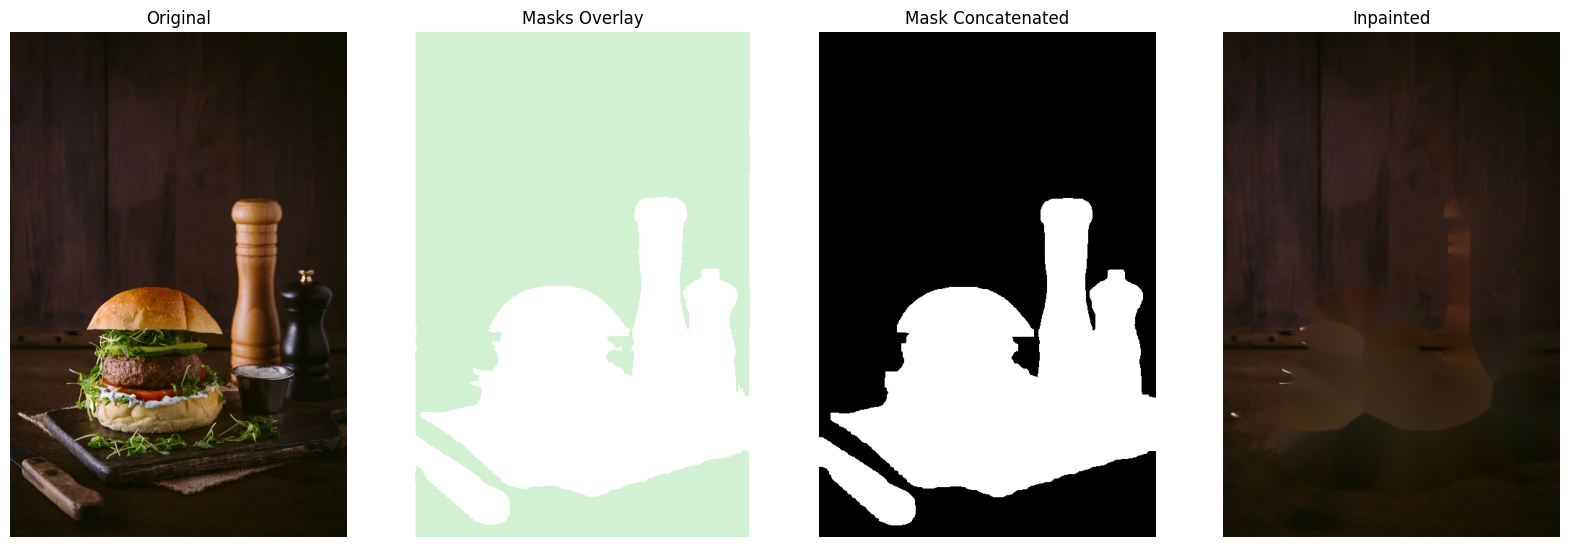

Processing image at D:/My Repos/eyes/images/lipstick_0.jpg, assigned name lipstick_0
Computing masks
41
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Filtering mask based on borders: 43.6 ; 828.4 ; 60.0 ; 1140.0
Filtered 39 masks based on touching sides of bbox
Computed masks
Inpainting masks
Inpainted masks
Processed image at D:/My Repos/eyes/images/lipstick_0.jpg


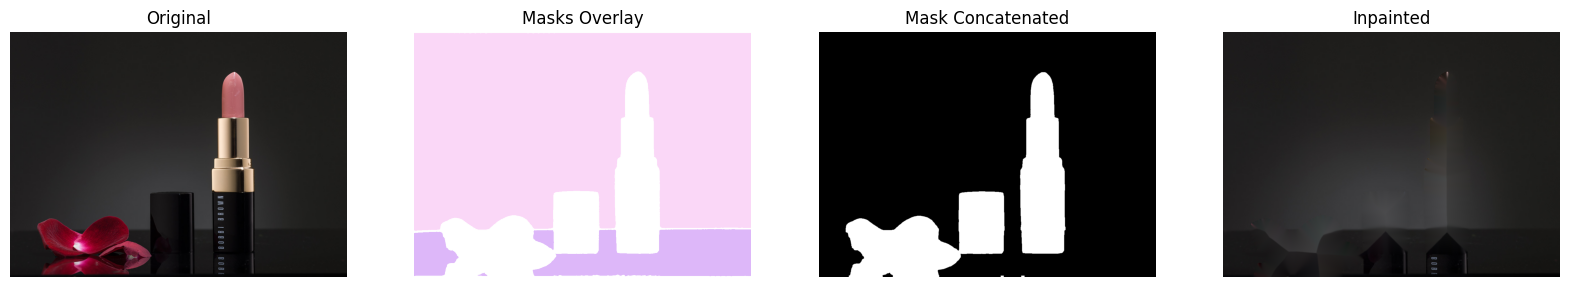

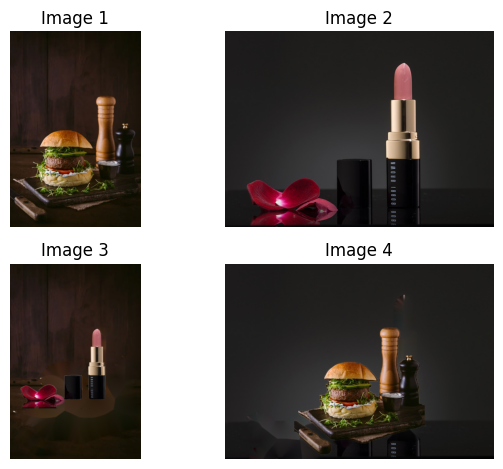

In [19]:
bg_switch = BackgroundSwitcher(images_path = "D:/My Repos/eyes/images/", use_sd_inpainting=False)
#img_data1 = bg_switch.process_image("food_2.jpg")
#img_data2 = bg_switch.process_image("product_2.jpg")
bg_switch.switch_foregrounds("burger_0.png","lipstick_0.jpg")

# Rought blob identification: Trying semantic segmentation

In [4]:
import torch
from PIL import Image
from torchvision import transforms

# Load the pre-trained model
model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# Load the image
input_image = Image.open(TMP_IMAGE_PATH)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

# Don't track gradients
with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

# Display the result
plt.imshow(output_predictions)

Using cache found in C:\Users\steph/.cache\torch\hub\pytorch_vision_v0.9.0
C:\Dev\Anaconda\envs\Ocus\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Dev\Anaconda\envs\Ocus\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'TMP_IMAGE_PATH' is not defined

# Rought blob identification: Trying traditional blob detection

In [ ]:
TMP_IMAGE_PATH = "D:/My Repos/eyes/images/product_1.jpg"

In [ ]:
import cv2
import numpy as np

# Read image
im = cv2.imread(TMP_IMAGE_PATH, cv2.IMREAD_GRAYSCALE)

# Setup SimpleBlobDetector parameters.
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 500

# Filter by Area.
#params.filterByArea = True
#params.minArea = 1500

# Filter by Circularity
#params.filterByCircularity = True
#params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
#params.filterByInertia = True
#params.minInertiaRatio = 0.01

# Create a detector with the parameters
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs
keypoints = detector.detect(im)

# Draw detected blobs as red circles
im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im_with_keypoints_rgb = cv2.cvtColor(im_with_keypoints, cv2.COLOR_BGR2RGB)

# Show keypoints

# Plot the image
im_rgb = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
plt.imshow(im_rgb)

# Plot each keypoint
filtered_keypoints = [k for k in keypoints if k.size > 10.0]
for keypoint in filtered_keypoints:
    plt.scatter(keypoint.pt[0], keypoint.pt[1], s=keypoint.size, c='r', marker='o')

plt.show()

In [ ]:
for keypoint in keypoints:
    print(f"Coordinates: {keypoint.pt}")
    print(f"Response: {keypoint.size}")